In [34]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
import import_ipynb
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [35]:
from qp import get_stocks # 1/PBR + GP/A
#from ncav import get_stocks # NCAV
#from super_value import get_stocks # PBR + PCR + PER + PSR
#from super_quality import get_stocks

importing Jupyter notebook from qp.ipynb


In [36]:
MODEL_NAME = 'qp'
DATA_DIR = 'data/daily/8-1'

In [37]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [38]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv


In [39]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date, False), axis=1)

2002-08-01 선정 기업 수 30
2003-08-01 선정 기업 수 30
2004-08-02 선정 기업 수 30
2005-08-01 선정 기업 수 30
2006-08-01 선정 기업 수 30
2007-08-01 선정 기업 수 30
2008-08-01 선정 기업 수 30
2009-08-03 선정 기업 수 30
2010-08-02 선정 기업 수 30
2011-08-01 선정 기업 수 30
2012-08-01 선정 기업 수 30
2013-08-01 선정 기업 수 30
2014-08-01 선정 기업 수 30
2015-08-03 선정 기업 수 30
2016-08-01 선정 기업 수 30
2017-08-01 선정 기업 수 30
2018-08-01 선정 기업 수 30


In [7]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data(df_account.iloc[0].start_date, df_account.iloc[len(df_account) - 1].end_date)

In [40]:
# 연도별 / 월별 수익률을 구한다.
df_account['monthly_yield'] = 0.0
df_account['monthly_yield'] = df_account['monthly_yield'].astype('object')
df_account['yearly_yield'] = 0.0

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date

        # 한 해의 가격 정보
        df_yearly_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]
        stocks = df_account.iloc[i].stocks

        # 종목별 월별 수익률 저장
        df_monthly_yield = pd.DataFrame()

        # 종목별 연간 수익률 저장
        #yearly_stock_yields = []
        
        # 종목별 수익률 구하기
        for stock in stocks:
            df_yearly_stock_price = df_yearly_price[df_yearly_price.Code == stock].reset_index()
            if len(df_yearly_stock_price) == 0:
                df_yield[stock] = [0] * 12
                yearly_stock_yields.append(0)
                continue

            # 월별로 groupby
            df_yearly_stock_price['year_month'] = df_yearly_stock_price.apply(lambda x: str(x.Date)[:7], axis=1)
            df_yearly_stock_price = df_yearly_stock_price[:-1]
            df_monthly_stock_yield = df_yearly_stock_price.groupby("year_month").agg({'Open': 'first', 'Close': 'last'}).reset_index()

            # 월별 수익률
            df_monthly_stock_yield['yield'] = 1.0
            for m, row in enumerate(df_monthly_stock_yield.iterrows()):
                if m == len(df_monthly_stock_yield) - 1:
                    df_monthly_stock_yield.at[row[0], 'yield'] = row[1]['Close'] / row[1]['Open']
                else:
                    df_monthly_stock_yield.at[row[0], 'yield'] = df_monthly_stock_yield.iloc[m + 1]['Open'] / row[1]['Open']
            
            monthly_yield = df_monthly_stock_yield['yield'].cumprod().tolist()

            if len(monthly_yield) < 12: # 가격 정보가 1년 내내 없는 경우. 상폐로 가정
                monthly_yield.extend([0] * (12 - len(monthly_yield)))
                #yearly_stock_yields.append(0)
            #else:
            #yearly_stock_yields.append(df_monthly_stock_yield.iloc[len(df_monthly_stock_yield)-1]['Close'] / df_monthly_stock_yield.iloc[0]['Open'])

            df_monthly_yield[stock] = monthly_yield
            
        df_monthly_yield['total'] = df_monthly_yield.mean(axis=1) 
        df_monthly_yield['prev_total'] = df_monthly_yield['total'].shift(1)
        df_monthly_yield['prev_total'] = df_monthly_yield['prev_total'].fillna(1.0)
        df_monthly_yield['monthly_yield'] = df_monthly_yield['total'] / df_monthly_yield['prev_total'] - 1.0
        
        # 월별 수익률
        df_account.at[i, 'monthly_yield'] = df_monthly_yield['monthly_yield'].tolist()
        # 연도별 수익률
        yearly_yield = df_monthly_yield.iloc[len(df_monthly_yield) - 1]['total']
        df_account.at[i, 'yearly_yield'] = yearly_yield

        print(start_date, end_date, yearly_yield)

2002-08-01 2003-08-01 0.8879762365508266
2003-08-01 2004-08-02 1.2174977270235061
2004-08-02 2005-08-01 2.2936425743972455
2005-08-01 2006-08-01 1.268105499408986
2006-08-01 2007-08-01 2.2381879759659493
2007-08-01 2008-08-01 0.8907481533895385
2008-08-01 2009-08-03 1.2321784138142307
2009-08-03 2010-08-02 1.3592951695503814
2010-08-02 2011-08-01 2.1934933207348766
2011-08-01 2012-08-01 1.6594789671644778
2012-08-01 2013-08-01 1.2730345221892523
2013-08-01 2014-08-01 1.2297753151869577
2014-08-01 2015-08-03 1.7807990654855028
2015-08-03 2016-08-01 1.4684543344344183
2016-08-01 2017-08-01 0.9461272689804289
2017-08-01 2018-08-01 1.5619789451690653
2018-08-01 2019-08-01 1.1979500657147306


In [42]:
# CAGR, 자산변화 구하기
df_account['cum_yield'] = df_account['yearly_yield'].cumprod()

df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['cum_yield'], 1/(i+1))
cagr = df_account.iloc[len(df_account) - 1]['cagr']

monthly_yields = []
for i in range(len(df_account)):
    monthly_yields.extend(df_account.iloc[i]['monthly_yield'])
cum_monthly_yield = np.cumprod(np.array(monthly_yields) + 1)

cagr_history = []
for i, val in enumerate(cum_monthly_yield.tolist()):
    year = (i + 1) / 12
    cagr_history.append(pow(val, 1 / year))

# 수익률 표준편차 구하기
filetered_monthly_yield = monthly_yields.copy()

# outlier 제거
filetered_monthly_yield.remove(max(filetered_monthly_yield))
filetered_monthly_yield.remove(min(filetered_monthly_yield))

std_monthly_yield =  statistics.stdev(filetered_monthly_yield)

In [43]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

for val in cum_monthly_yield:
    if val > max_yield:
        max_yield = val
        min_yield = val
        mdd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        mdd = (1.0 - min_yield / max_yield) * 100.0
        mdd_duration += 1

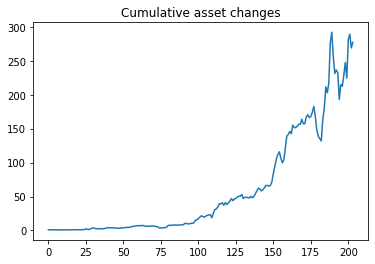

In [44]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cum_monthly_yield)), cum_monthly_yield)
plt.title('Cumulative asset changes')
plt.show()

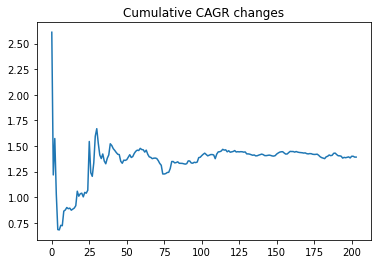

In [45]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cagr_history)), cagr_history, marker='', linestyle='-')
plt.title('Cumulative CAGR changes')
plt.show()

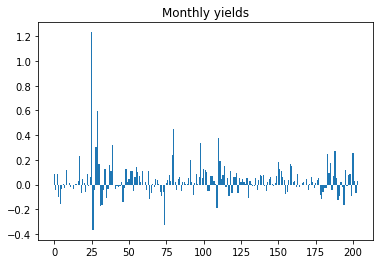

In [46]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(monthly_yields)), monthly_yields)
plt.title("Monthly yields")
plt.show()

In [47]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_monthly_yield,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Note |
+-----------+--------+--------+--------------+--------+------+
|    8-1    | 39.21% | 33.91% |      3       | 0.1072 |      |
+-----------+--------+--------+--------------+--------+------+
